<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Activation, Flatten,
    LSTM, SimpleRNN, Embedding
)
from sklearn.model_selection import train_test_split


In [3]:
# # Descargar la carpeta de dataset
# import os
# import gdown
# if os.access('data_volunteers.json', os.F_OK) is False:
#     url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
#     output = 'data_volunteers.json'
#     gdown.download(url, output, quiet=False)
# else:
#     print("El dataset ya se encuentra descargado")

In [4]:
import requests

url = "https://convai.io/data/data_tolokers.json"
response = requests.get(url)

with open("data_tolokers.json", "wb") as f:
    f.write(response.content)

In [5]:
# dataset_file
import json

text_file = "data_tolokers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [6]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("'d", " had")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    return txt.strip()

for line in data:
    for i in range(len(line['dialog']) - 1):
        input_text = clean_text(line['dialog'][i]['text'])
        output_text = clean_text(line['dialog'][i + 1]['text'])

        if len(input_text) >= max_len or len(output_text) >= max_len:
            continue

        # Agregar tokens especiales
        output_sentence = output_text + ' <eos>'
        output_sentence_input = '<sos> ' + output_text

        input_sentences.append(input_text)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 12712


In [8]:
print(input_sentences[1])


print(output_sentences[1])

print(output_sentences_inputs[1])



hey
what do you do <eos>
<sos> what do you do


In [9]:
def mostrar_conversacion(index: int = 0):
    conv = data[index]
    p1 = conv['participant1_id']
    p2 = conv['participant2_id']
    print(f"🟢 Conversación #{index} — P1: {p1} | P2: {p2}\n")

    for i, turno in enumerate(conv['dialog']):
        speaker = "P1" if turno['id'] == p1 else "P2"
        print(f"{i+1}. {speaker}: {turno['text']}")
mostrar_conversacion(0)


🟢 Conversación #0 — P1: {'class': 'User', 'user_id': 'User 00686'} | P2: {'class': 'Bot', 'user_id': 'Bot 002'}

1. P2: I love iphone! i just bought new iphone!
2. P2: Thats good for you, i'm not very into new tech
3. P2: I am a college student and i am a college student
4. P2: I am go to gym and live on donations
5. P2: I am a vegan and i am in the midwest
6. P2: So vegan... i have dogs maybe i should told then that they may eat cheap salads insted of meat
7. P2: I would not mind having them in the office that would be hard for me
8. P2: Dogs or vegan in office?
9. P2: I am a vegetarian so i am vegan
10. P2: Strange answer
11. P2: I guess i just do not know what to ps4 experience with.


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### Obtener word2idx_inputs, max_input_len

In [10]:
MAX_VOCAB_SIZE = 8000

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 2439
Sentencia de entrada más larga: 10


#### word2idx_outputs, max_out_len, num_words_output

In [13]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2510
Sentencia de salida más larga: 11


#### encoder_input_sequences, decoder_output_sequences, decoder_targets

In [14]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 12712
encoder_input_sequences shape: (12712, 10)
decoder_input_sequences shape: (12712, 11)


In [15]:
from tensorflow.keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(12712, 11, 2511)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [16]:
import gdown
import os
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=8aec3d2f-ce78-4881-a6e2-7b5aaacec69a
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:09<00:00, 57.3MB/s]


In [27]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz


--2025-04-13 14:27:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.121, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  24.2MB/s    in 54s     

2025-04-13 14:28:43 (23.4 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [17]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [28]:
model_embeddings = FasttextEmbeddings()

In [29]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
max_input_len

10

In [30]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_input')  #tupla de un solo elemento

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,), name='decoder_input')
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_embedded  = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedded , initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 300)   │    731,700 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 11, 128)   │    321,408 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 11, 128), │    131,584 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 11, 2511)  │    323,919 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,728,259 (6.59 MB)

 Trainable params: 996,559 (3.80 MB)

 Non-trainable params: 731,700 (2.79 MB)

In [22]:
from tensorflow.keras.utils import plot_model


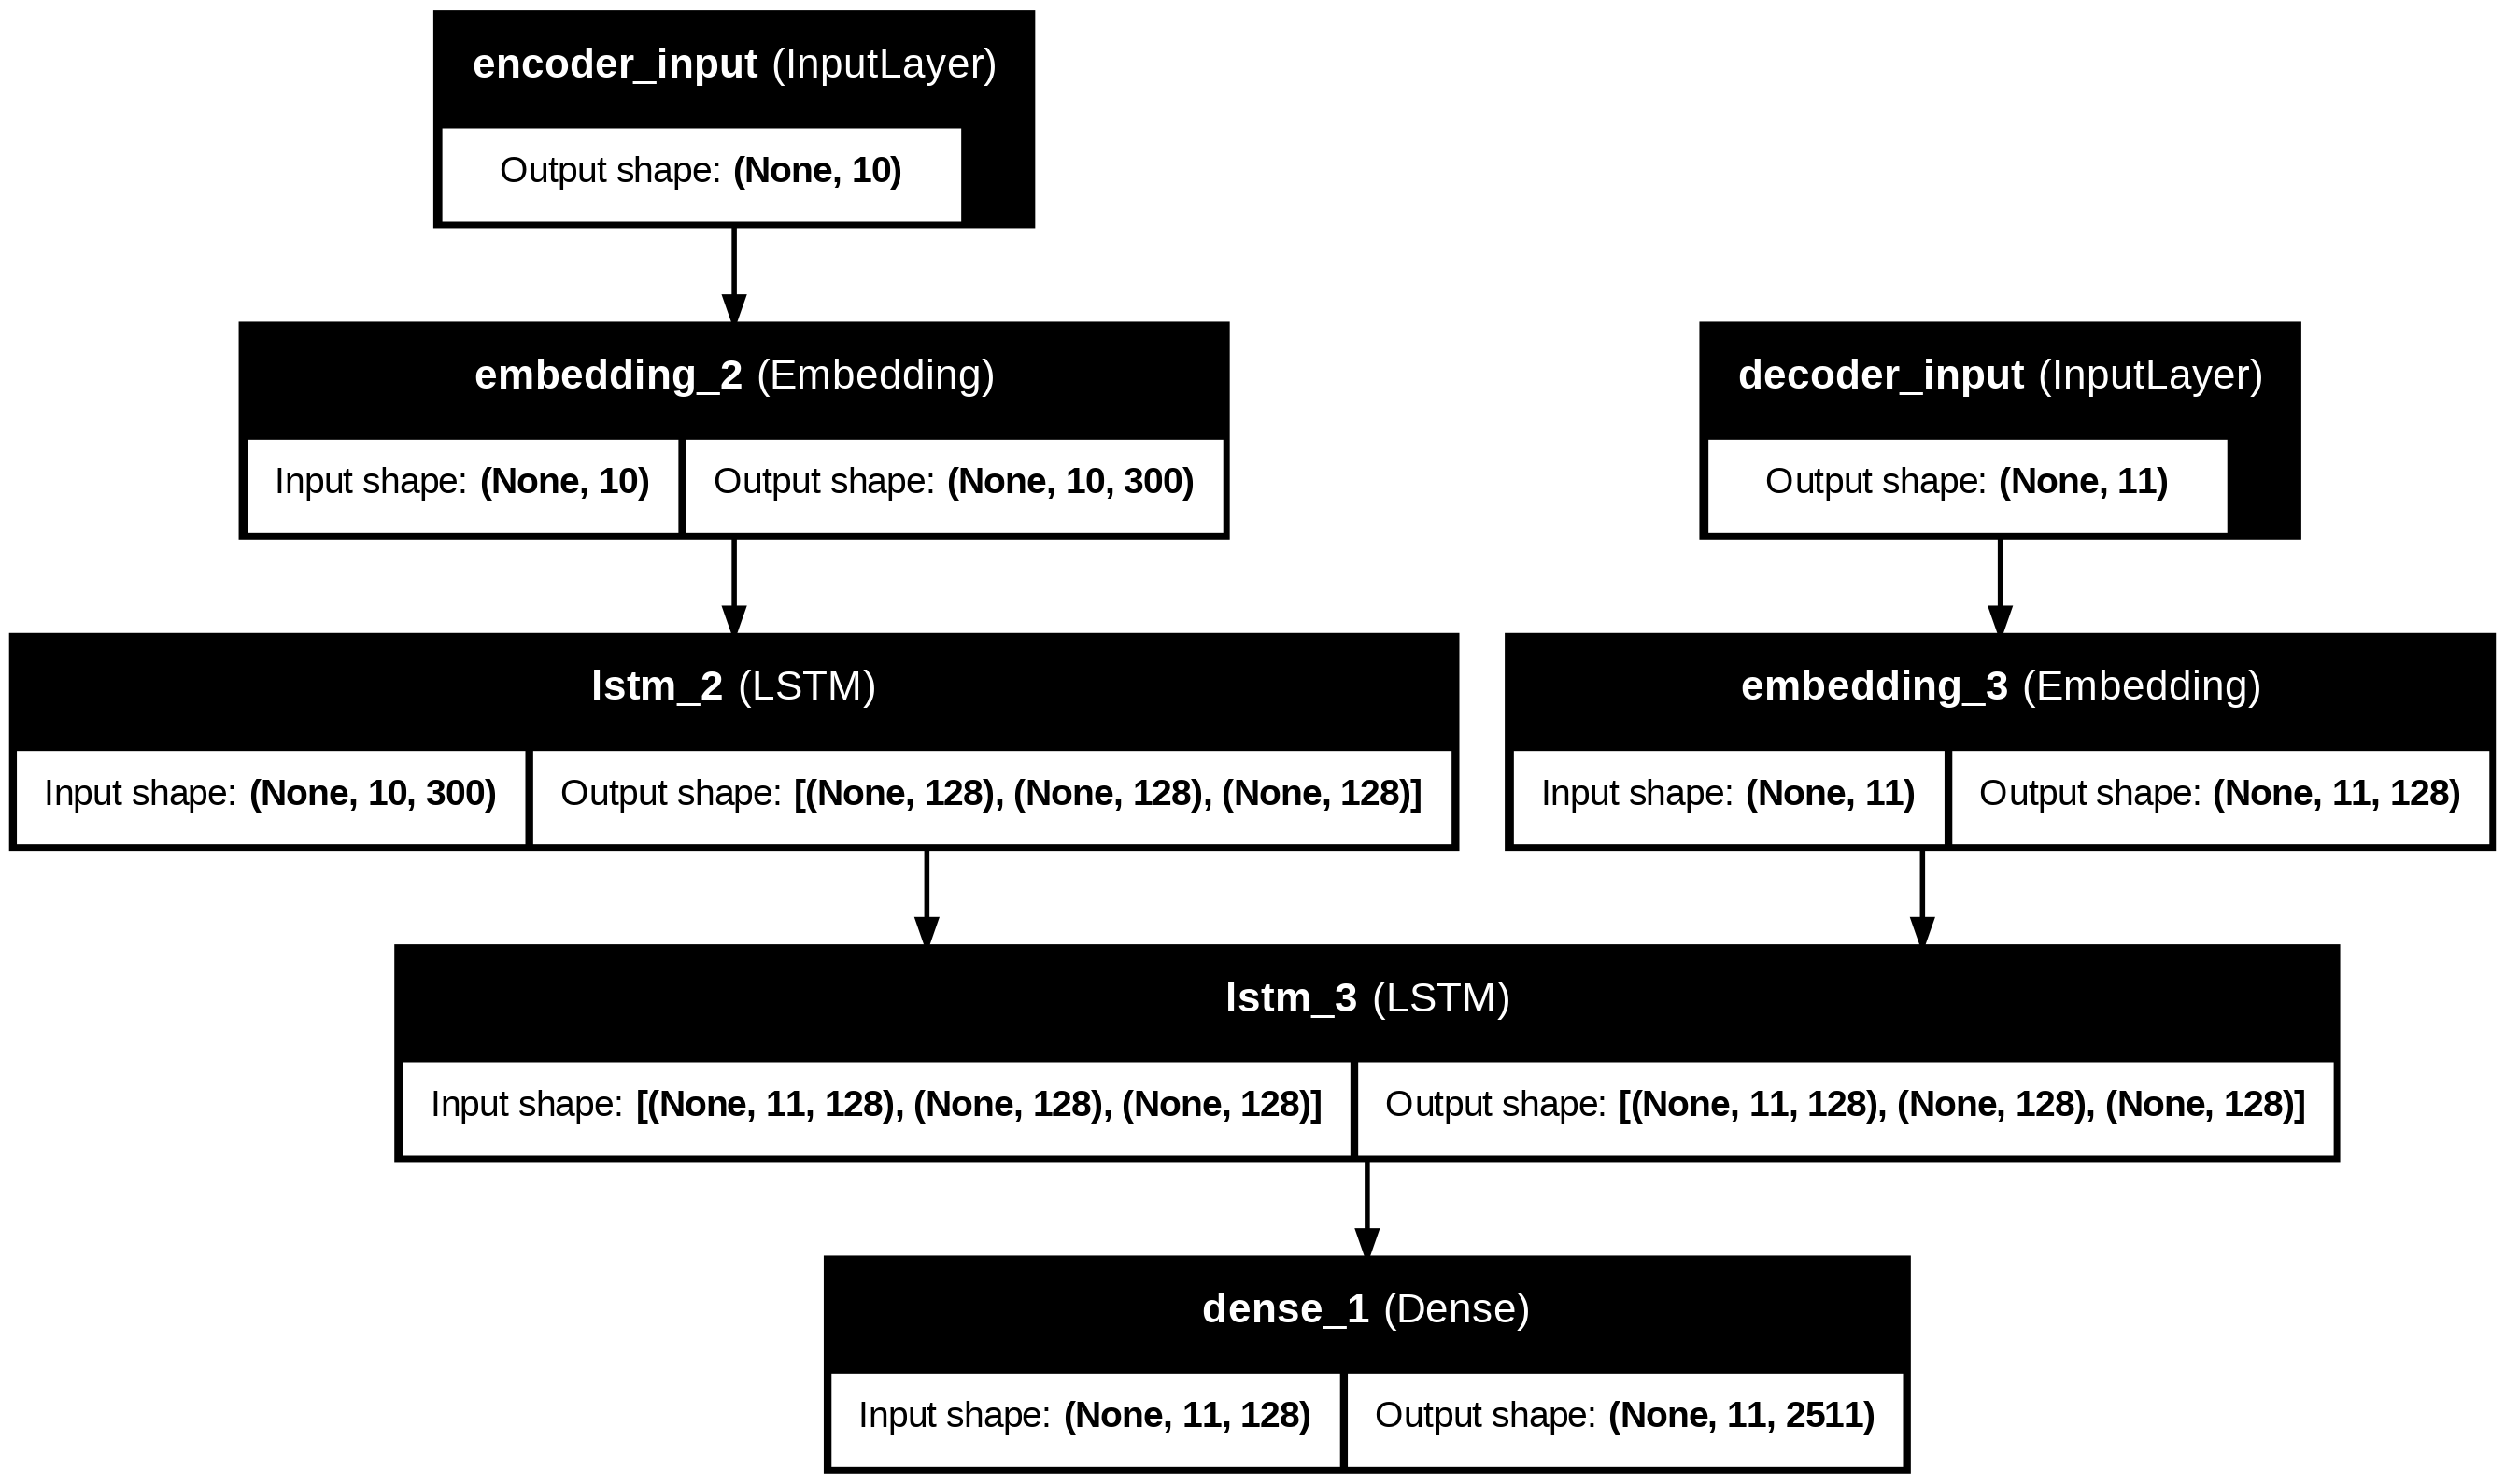

In [31]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

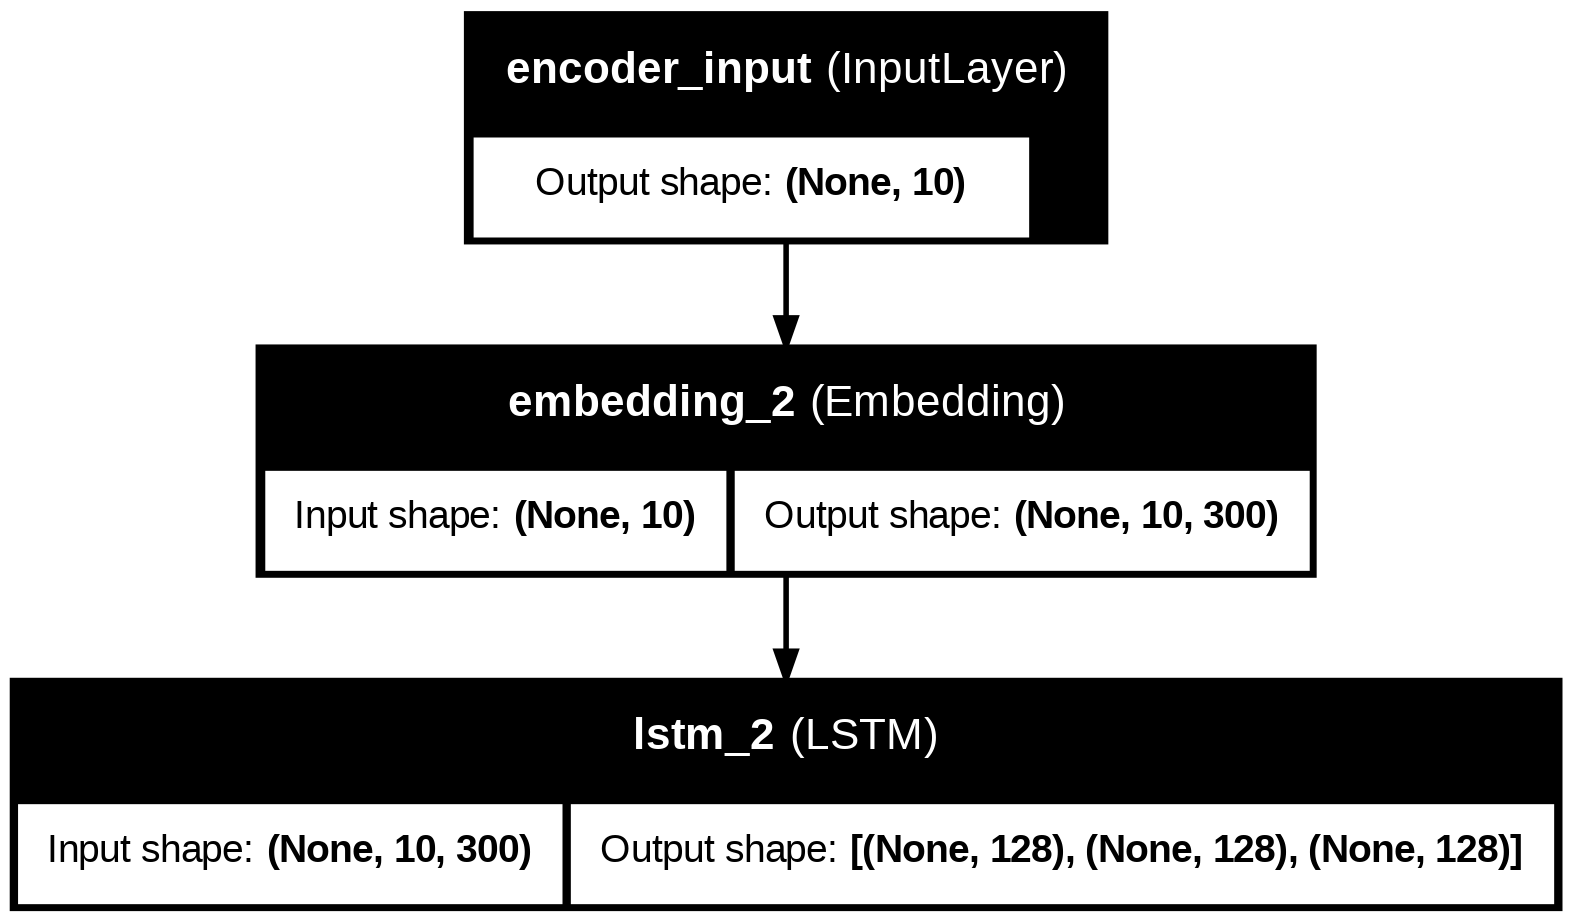

In [32]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

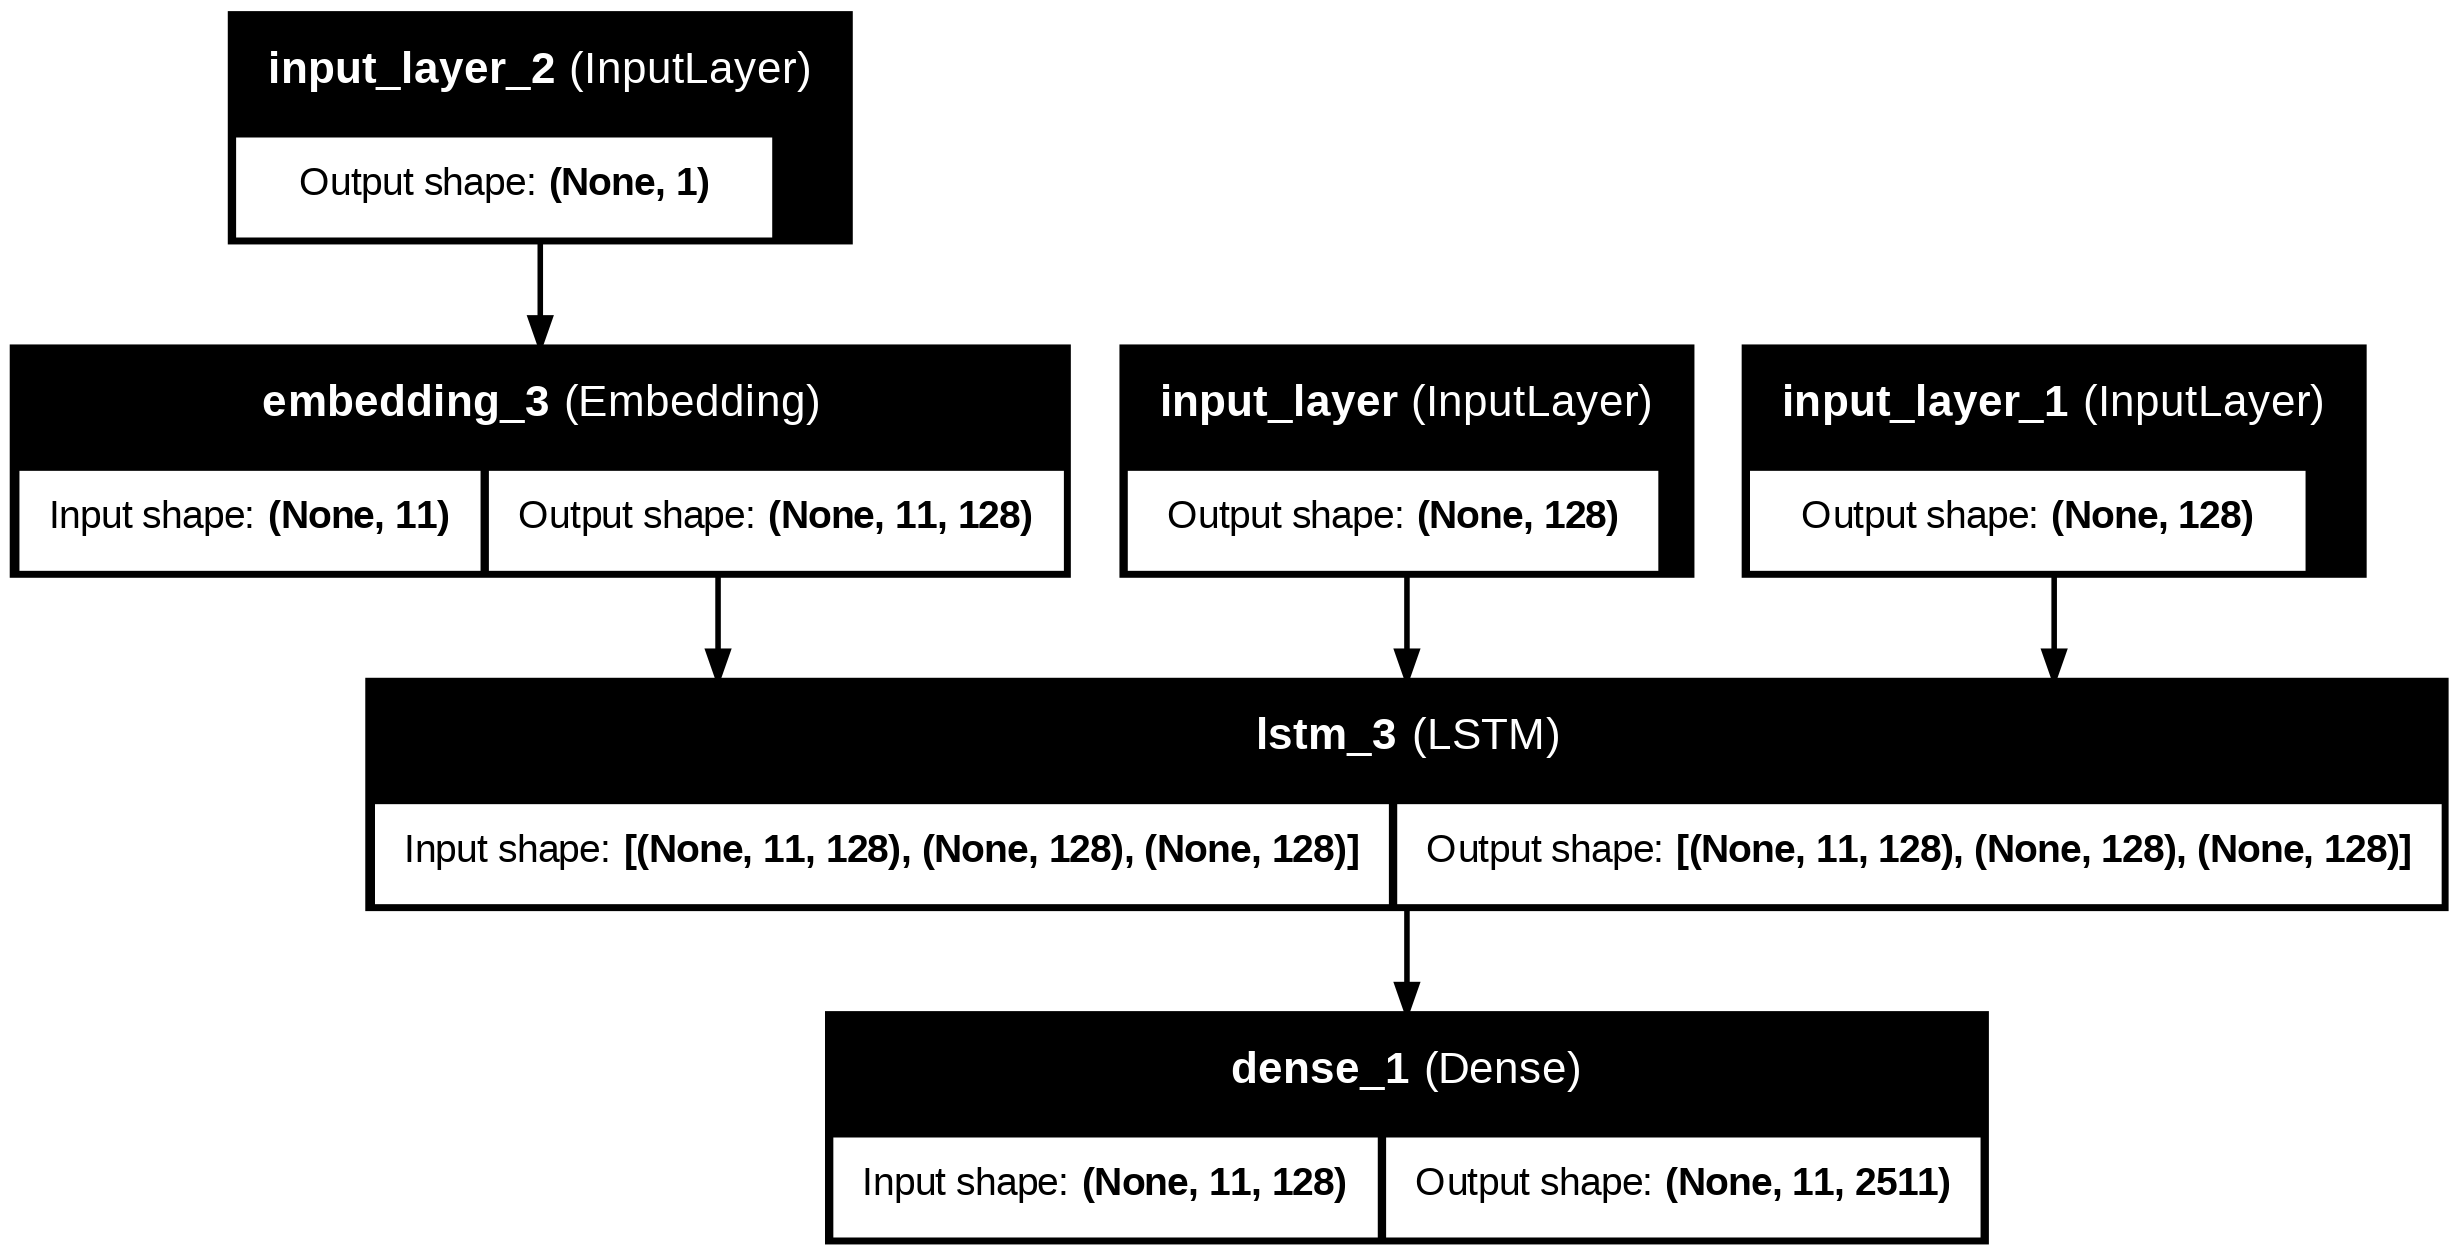

In [34]:
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.5713 - loss: 3.4085 - val_accuracy: 0.6572 - val_loss: 2.0104
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - accuracy: 0.6799 - loss: 1.8434 - val_accuracy: 0.6929 - val_loss: 1.8095
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.7133 - loss: 1.6342 - val_accuracy: 0.7132 - val_loss: 1.6855
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.7277 - loss: 1.5156 - val_accuracy: 0.7184 - val_loss: 1.6124
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.7327 - loss: 1.4248 - val_accuracy: 0.7255 - val_loss: 1.5609
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.7380 - loss: 1.3766 - val_accuracy: 0.7301 - val_loss: 1.5210
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.7460 - loss: 1.3104 - val_accuracy: 0.7354 - val_loss: 1.4890
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.7555 - loss: 1.25

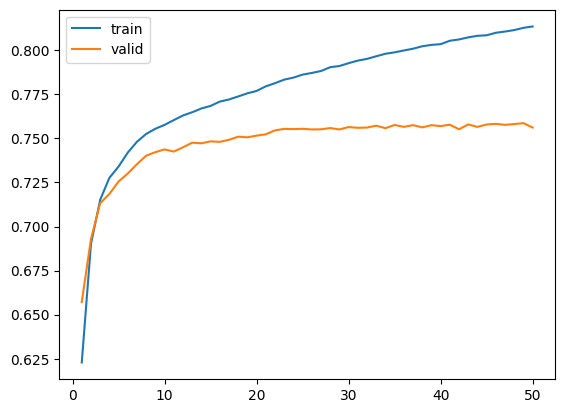

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [36]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [52]:
def generate_answer(input_seq):
    states_value = encoder_model.predict(input_seq)

    # inicializar el decoder con <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    #  generar tokens de la respuesta, uno por uno
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        idx = np.argmax(output_tokens[0, 0, :])

        # Fin de la respuesta
        if idx == eos:
            break

        # Convertir idx a palabra (solo si válida)
        if idx > 0:
            word = idx2word_target.get(idx, '')
            output_sentence.append(word)

        # Actualizar entrada al decoder y estados
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [57]:
i = 1
input_seq = encoder_input_sequences[i:i+1]

print("🧾 Pregunta:", input_sentences[i])
print("✅ Respuesta real:", output_sentences[i])
print("🤖 Respuesta generada:", generate_answer(input_seq))


🧾 Pregunta: hey
✅ Respuesta real: what do you do <eos>
input:  [[ 0  0  0  0  0  0  0  0  0 20]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🤖 Respuesta generada: hi how are you doing


In [92]:
def test_custom_question(question: str) -> str:
    """
    Prueba el modelo encoder-decoder con una pregunta custom.

    Parámetros:
        question (str): La pregunta en texto.

    Retorna:
        str: La respuesta generada por el modelo.
    """
    tokens = question.lower().split()
    unk_token = word2idx_inputs.get('<unk>', 0)
    sequence = [word2idx_inputs.get(token, unk_token) for token in tokens]
    sequence_padded = pad_sequences([sequence], maxlen=max_input_len, padding='pre')
    answer = generate_answer(sequence_padded)
    return answer

In [93]:
custom_question = "Do you read?"
response = test_custom_question(custom_question)
print("❓ Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

input:  [[0 0 0 0 0 0 0 4 2 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
❓ Pregunta: Do you read?
🤖 Respuesta generada: i do not know


In [94]:
custom_question = "Do you have any pet?"
response = test_custom_question(custom_question)
print("❓ Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

input:  [[ 0  0  0  0  0  4  2 14 55  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
❓ Pregunta: Do you have any pet?
🤖 Respuesta generada: i do not have any pets


In [95]:
custom_question = "Where are you from?"
response = test_custom_question(custom_question)
print("❓ Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

input:  [[ 0  0  0  0  0  0 30  6  2  0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
❓ Pregunta: Where are you from?
🤖 Respuesta generada: i am a student in cali


In [96]:
custom_question = "where do you study in cali?"
response = test_custom_question(custom_question)
print("❓ Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

input:  [[  0   0   0   0  30   4   2 263  27   0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
❓ Pregunta: where do you study in cali?
🤖 Respuesta generada: i am a teacher and you


In [97]:
custom_question = "what subject do you teach?"
response = test_custom_question(custom_question)
print("❓ Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

input:  [[  0   0   0   0   0   7 959   4   2   0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
❓ Pregunta: what subject do you teach?
🤖 Respuesta generada: i do not know
